# **Step 1: Setup & Dataset Load**

In [76]:
#req. packages
!pip install scikit-learn streamlit pyngrok --quiet

#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import datetime

#loading the csv dataset
df = pd.read_csv("online_retail.csv", encoding="ISO-8859-1")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# **Step 2: Data Preprocessing**

In [77]:
#removing missing CustomerID
df=df.dropna(subset=['CustomerID'])
#removing cancelled invoices (InvoiceNo starting with 'C')
df=df[~df['InvoiceNo'].astype(str).str.startswith('C')]
#removing negative or zero quantities/prices
df=df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
#creating TotalPrice=Quantity * UnitPrice
df['TotalPrice']=df['Quantity'] * df['UnitPrice']
#converting InvoiceDate to datetime
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# **Step 3: Exploratory Data Analysis (EDA)**

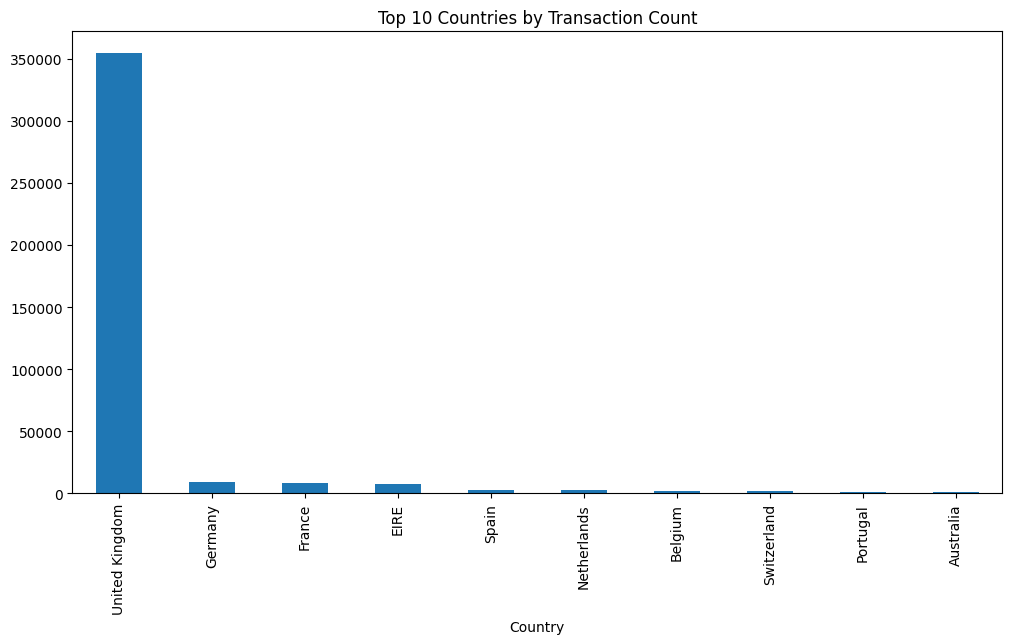

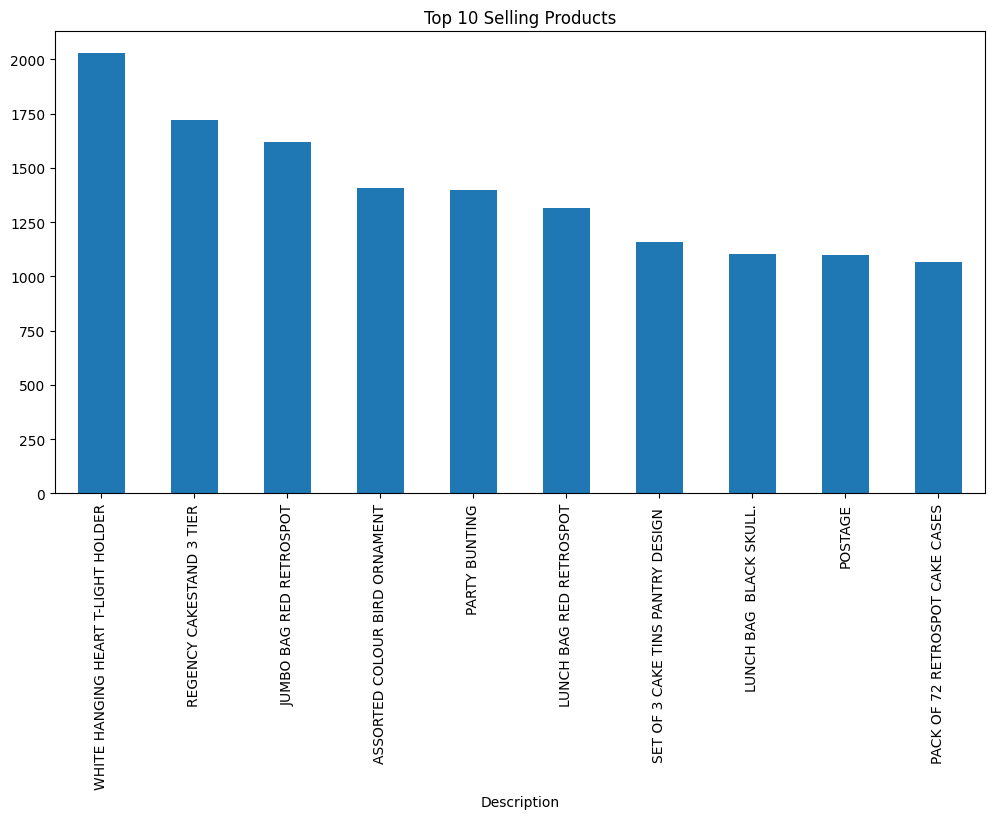

/tmp/ipython-input-2900409578.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('InvoiceDate').resample('M')['InvoiceNo'].count().plot(figsize=(12,6))


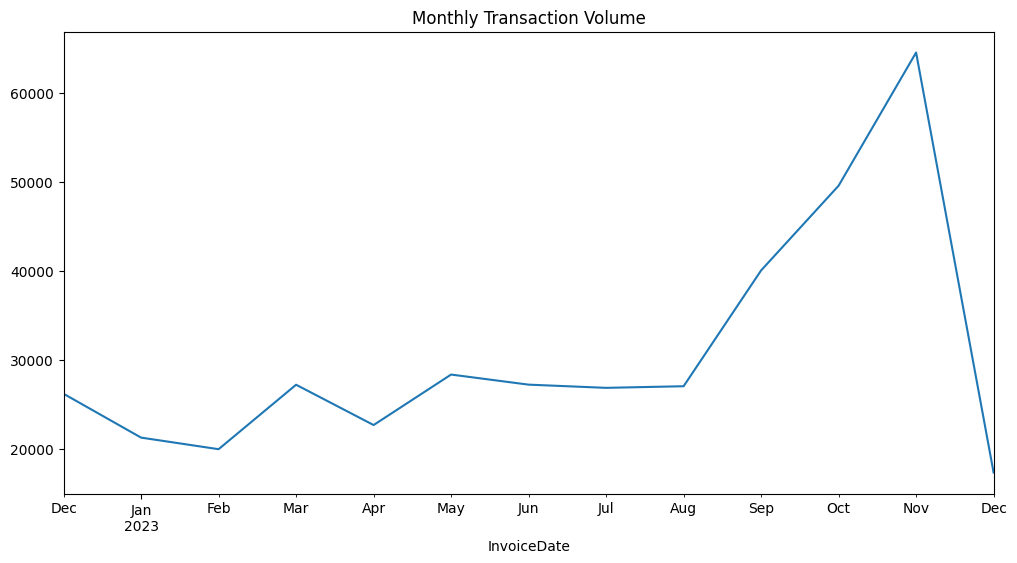

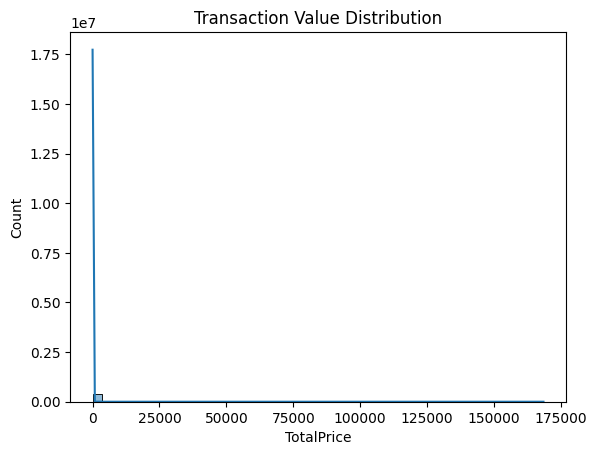

In [78]:
#Transactions per country
plt.figure(figsize=(12,6))
df['Country'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Countries by Transaction Count")
plt.show()

#Top selling products
plt.figure(figsize=(12,6))
df['Description'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Selling Products")
plt.show()

#Purchases over time
df.set_index('InvoiceDate').resample('M')['InvoiceNo'].count().plot(figsize=(12,6))
plt.title("Monthly Transaction Volume")
plt.show()

#Distribution of TotalPrice per transaction
sns.histplot(df['TotalPrice'], bins=50, kde=True)
plt.title("Transaction Value Distribution")
plt.show()

/tmp/ipython-input-3603467432.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales=df_trends.resample("M")["Quantity"].sum()


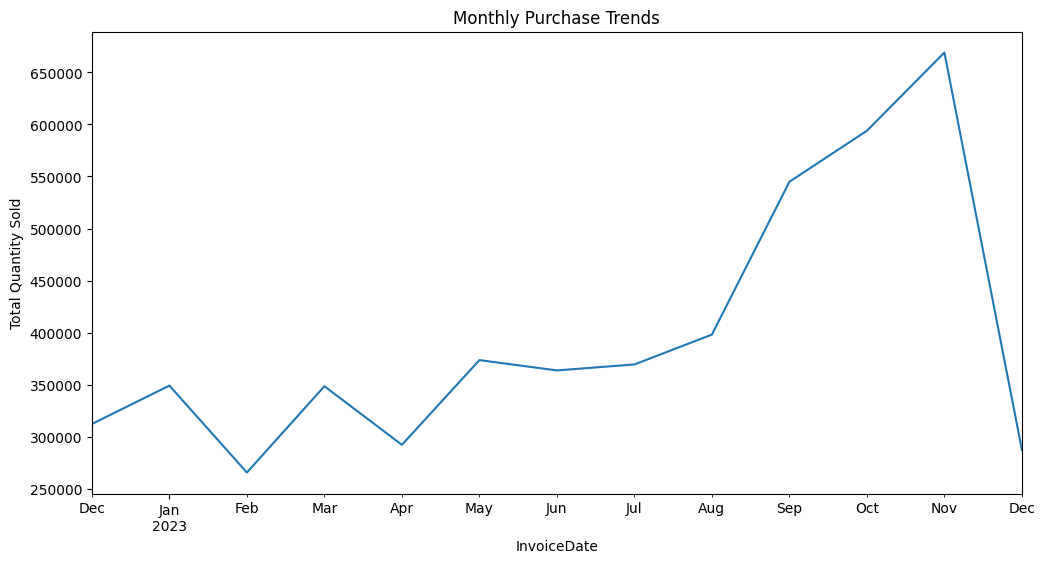

In [79]:
#Purchase Trends' Analysis
df_trends=df.copy()
df_trends["InvoiceDate"]=pd.to_datetime(df_trends["InvoiceDate"])
df_trends.set_index("InvoiceDate", inplace=True)
monthly_sales=df_trends.resample("M")["Quantity"].sum()
plt.figure(figsize=(12,6))
monthly_sales.plot()
plt.title("Monthly Purchase Trends")
plt.ylabel("Total Quantity Sold")
plt.show()

# **Step 4: RFM Feature Engineering**

In [80]:
#Reference date(latest date in dataset)
ref_date=df['InvoiceDate'].max()
#RFM calculation
rfm=df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date-x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns=['CustomerID','Recency','Frequency','Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


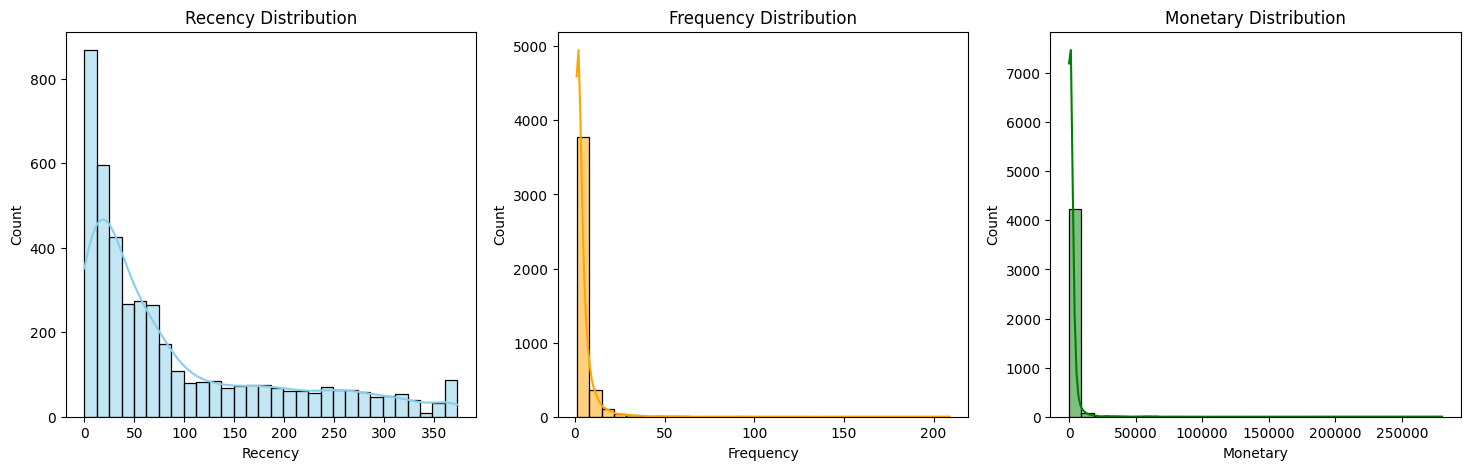

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes=plt.subplots(1, 3, figsize=(18,5))
sns.histplot(rfm["Recency"], bins=30, ax=axes[0], kde=True, color="skyblue")
axes[0].set_title("Recency Distribution")
sns.histplot(rfm["Frequency"], bins=30, ax=axes[1], kde=True, color="orange")
axes[1].set_title("Frequency Distribution")
sns.histplot(rfm["Monetary"], bins=30, ax=axes[2], kde=True, color="green")
axes[2].set_title("Monetary Distribution")
plt.show()

### Interpretation of RFM Distributions
- Recency shows that most customers purchased recently, with a long tail of inactive customers.  
- Frequency is skewed: most customers have made only a few transactions.  
- Monetary is also skewed: a few customers account for high spend.  
This highlights the need for segmentation instead of treating all customers the same.

# **Step 5: Clustering**

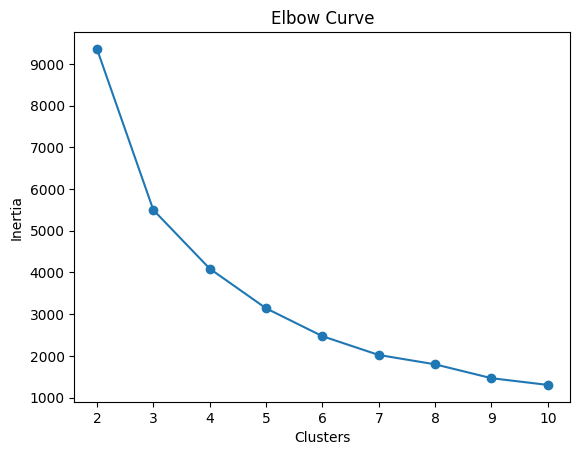

,Recency,Frequency,Monetary
Cluster,,,
0,42.702685,3.682711,1359.049284
1,247.075914,1.552015,480.617480
2,6.384615,82.538462,127338.313846
3,14.500000,22.333333,12709.090490


In [82]:
#Scale RFM
scaler=StandardScaler()
rfm_scaled=scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

#Elbow Method
inertia=[]
for k in range(2,11):
    kmeans=KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2,11), inertia, marker='o')
plt.title("Elbow Curve")
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.show()

#Choose k=4 (common in RFM) and run clustering
kmeans=KMeans(n_clusters=4, random_state=42)
rfm['Cluster']=kmeans.fit_predict(rfm_scaled)

#Cluster profiling
rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()

In [83]:
from sklearn.metrics import silhouette_score
inertia=kmeans.inertia_
silhouette=silhouette_score(rfm_scaled, kmeans.labels_)
print(f"Inertia: {inertia}")
print(f"Silhouette Score: {silhouette:.3f}")

Inertia: 4092.14430525428
Silhouette Score: 0.616


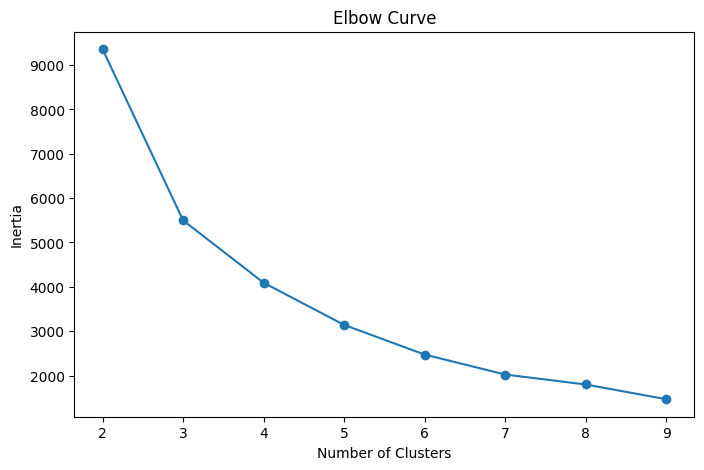

In [84]:
inertia_scores=[]
for k in range(2, 10):
    km=KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia_scores.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(2, 10), inertia_scores, marker="o")
plt.title("Elbow Curve")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [85]:
#cluster interpretation logic, cluster center(og. scale)
centers=scaler.inverse_transform(kmeans.cluster_centers_)
cluster_summary=pd.DataFrame(centers, columns=["Recency", "Frequency", "Monetary"])
cluster_summary["Cluster"]=cluster_summary.index
print("Cluster Summary (RFM averages):")
print(cluster_summary)

Cluster Summary (RFM averages):
      Recency  Frequency       Monetary  Cluster
0   42.702685   3.682711    1359.049284        0
1  247.075914   1.552015     480.617480        1
2    6.384615  82.538462  127338.313846        2
3   14.500000  22.333333   12709.090490        3


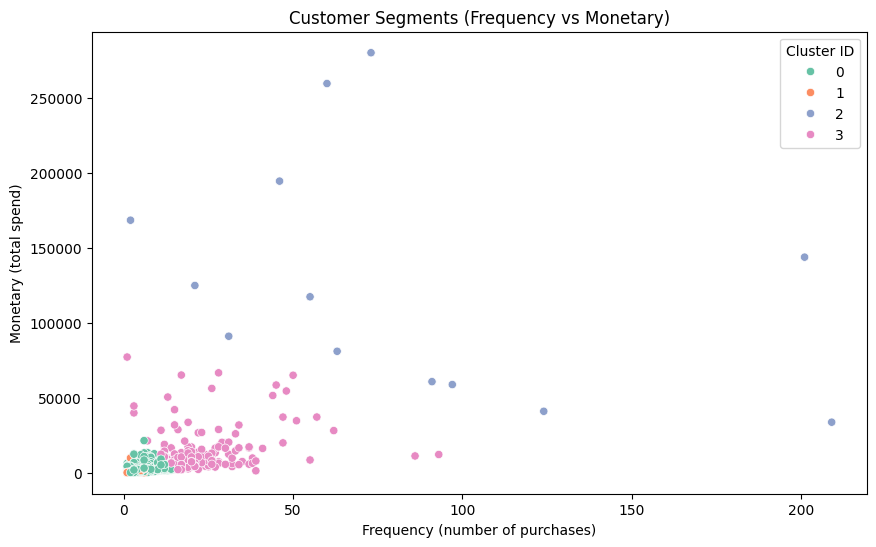

In [86]:
rfm["Cluster"]=kmeans.labels_
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x="Frequency", y="Monetary", hue="Cluster", palette="Set2")
plt.title("Customer Segments (Frequency vs Monetary)")
plt.xlabel("Frequency (number of purchases)")
plt.ylabel("Monetary (total spend)")
plt.legend(title="Cluster ID")
plt.show()

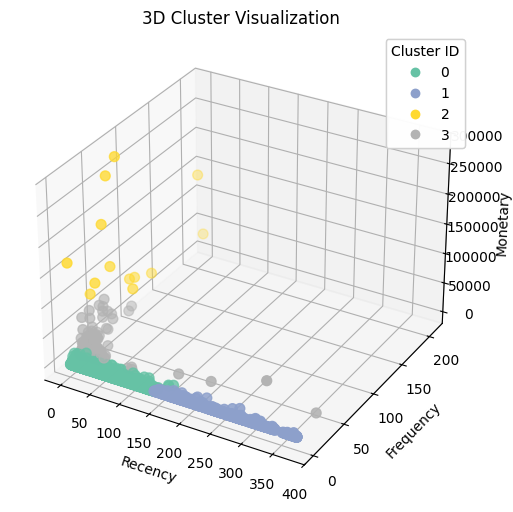

In [87]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111, projection='3d')
#scatter plot with cluster colors
scatter=ax.scatter(
    rfm["Recency"],
    rfm["Frequency"],
    rfm["Monetary"],
    c=rfm["Cluster"],
    cmap="Set2",
    s=50
)
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.title("3D Cluster Visualization")
#legend with cluster id
legend1=ax.legend(*scatter.legend_elements(), title="Cluster ID", loc="best")
ax.add_artist(legend1)
plt.show()

# **Step 6: Segment Naming**

In [88]:
def assign_segment(row, cluster_summary):
    rec, freq, mon=row["Recency"], row["Frequency"], row["Monetary"]
    cluster=row["Cluster"]
    center=cluster_summary.loc[cluster]
    if (freq >= center["Frequency"]) and (mon >= center["Monetary"]):
        return "High-Value"
    elif (freq < center["Frequency"]) and (mon >= center["Monetary"]):
        return "Occasional"
    elif (freq >= center["Frequency"]) and (mon < center["Monetary"]):
        return "Regular"
    else:
        return "At-Risk"
rfm["Segment"]=rfm.apply(lambda row: assign_segment(row, cluster_summary), axis=1)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster,Segment
0,12346.0,325,1,77183.60,3,Occasional
1,12347.0,1,7,4310.00,0,High-Value
2,12348.0,74,4,1797.24,0,High-Value
3,12349.0,18,1,1757.55,0,Occasional
4,12350.0,309,1,334.40,1,At-Risk


# **Step 7: Collaborative Filtering (Product Recommendations)**

In [89]:
from sklearn.metrics.pairwise import cosine_similarity
#creating customer-product matrix
cust_prod=df.pivot_table(index='CustomerID', columns='Description', values='Quantity', fill_value=0)
#cosine similarities between products
product_similarity=cosine_similarity(cust_prod.T)
product_similarity_df=pd.DataFrame(product_similarity,
                                     index=cust_prod.columns,
                                     columns=cust_prod.columns)

def recommend_products(product_name, n=5):
    if product_name not in product_similarity_df.columns:
        return ["Product not found"]
    similar=product_similarity_df[product_name].sort_values(ascending=False)[1:n+1]
    return list(similar.index)
#example
recommend_products("WHITE HANGING HEART T-LIGHT HOLDER")

['GIN + TONIC DIET METAL SIGN',
 'TEA TIME TEA TOWELS ',
 'FAIRY CAKE FLANNEL ASSORTED COLOUR',
 'DOORMAT FAIRY CAKE',
 'RED HANGING HEART T-LIGHT HOLDER']

# **Step 8: Save Model for Streamlit**

In [90]:
import joblib
joblib.dump(kmeans, "rfm_kmeans.pkl")
joblib.dump(scaler, "scaler.pkl")
product_similarity_df.to_pickle("product_similarity.pkl")

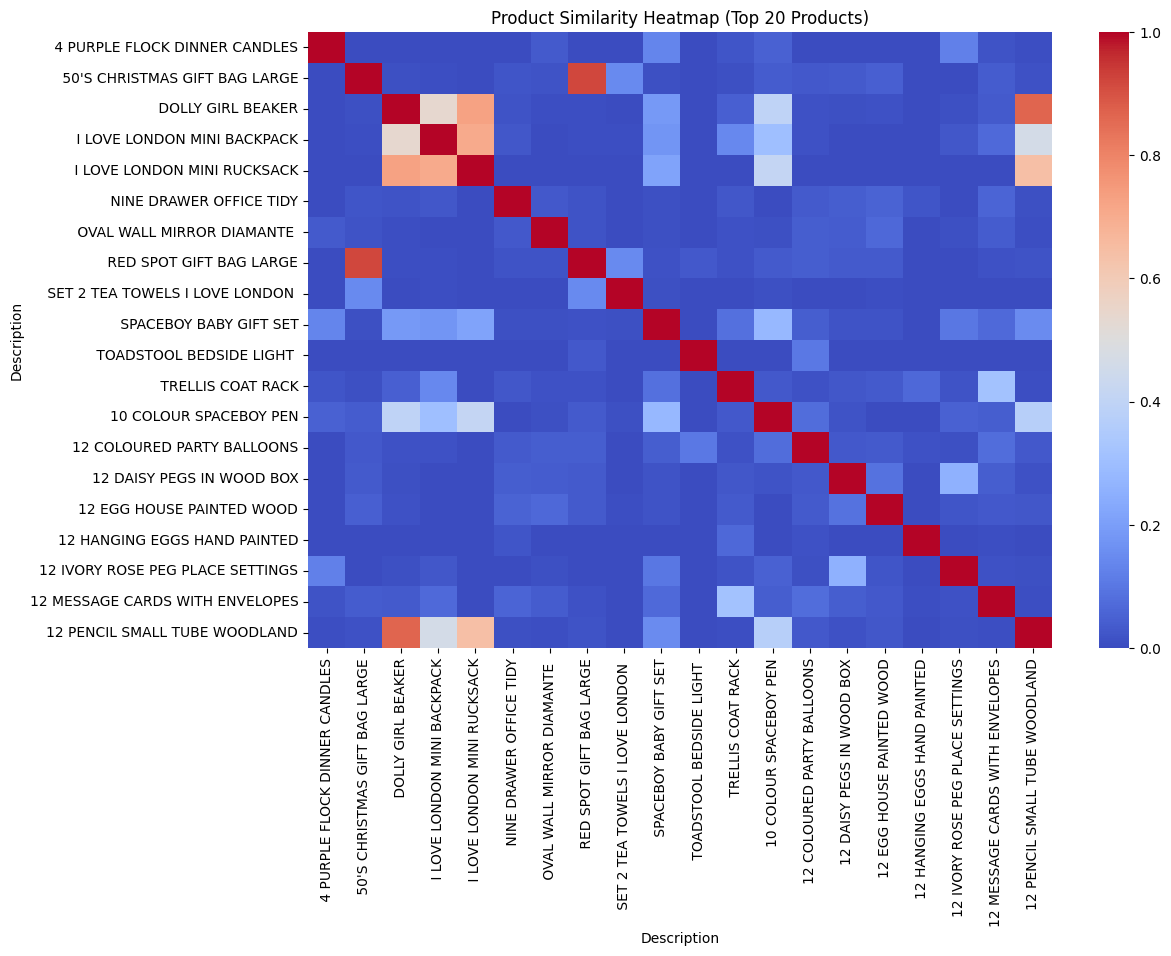

In [91]:
#using the dataFrame
plt.figure(figsize=(12,8))
sns.heatmap(product_similarity_df.iloc[:20, :20], cmap="coolwarm")
plt.title("Product Similarity Heatmap (Top 20 Products)")
plt.show()

### Product Recommendation Insight
The heatmap shows strong similarities between related products, confirming that collaborative filtering captures meaningful co-purchase patterns.


In [92]:
print(df["Description"].unique()[:50])

['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN'
 'CREAM CUPID HEARTS COAT HANGER' 'KNITTED UNION FLAG HOT WATER BOTTLE'
 'RED WOOLLY HOTTIE WHITE HEART.' 'SET 7 BABUSHKA NESTING BOXES'
 'GLASS STAR FROSTED T-LIGHT HOLDER' 'HAND WARMER UNION JACK'
 'HAND WARMER RED POLKA DOT' 'ASSORTED COLOUR BIRD ORNAMENT'
 "POPPY'S PLAYHOUSE BEDROOM " "POPPY'S PLAYHOUSE KITCHEN"
 'FELTCRAFT PRINCESS CHARLOTTE DOLL' 'IVORY KNITTED MUG COSY '
 'BOX OF 6 ASSORTED COLOUR TEASPOONS' 'BOX OF VINTAGE JIGSAW BLOCKS '
 'BOX OF VINTAGE ALPHABET BLOCKS' 'HOME BUILDING BLOCK WORD'
 'LOVE BUILDING BLOCK WORD' 'RECIPE BOX WITH METAL HEART'
 'DOORMAT NEW ENGLAND' 'JAM MAKING SET WITH JARS'
 'RED COAT RACK PARIS FASHION' 'YELLOW COAT RACK PARIS FASHION'
 'BLUE COAT RACK PARIS FASHION' 'BATH BUILDING BLOCK WORD'
 'ALARM CLOCK BAKELIKE PINK' 'ALARM CLOCK BAKELIKE RED '
 'ALARM CLOCK BAKELIKE GREEN' 'PANDA AND BUNNIES STICKER SHEET'
 'STARS GIFT TAPE ' 'INFLATABLE POLITICAL GLOBE '
 'VINTAGE HEADS AND TAILS 